This notebook is based on https://www.kaggle.com/code/meetbabariya/ridge-regression-no-leak.  
The following modifications have been made:
- Changed the model to LightGBM
- Cross-validation using time series split every 90 days

In [1]:
import os
import gc
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from tqdm.auto import tqdm
import lightgbm as lgb

# Set pandas decimal display precision to 10 digits
pd.set_option('display.precision', 4)

In [2]:
class CFG:
    exp_name = "exp003-4_kaggle"
    seed = 42
    wandb = False
    model = "lgb"
    objective = "regression"
    metric = "rmse"
    n_estimators = 200
    learning_rate = 0.02
    subsample = 0.8
    sub = True # Set wandb=False and turn off Internet

# Preprocessing

In [3]:
# Make folders
os.makedirs("/kaggle/working/models", exist_ok=True)

# ------------------ Data Loading ------------------
DATA_DIR = "/kaggle/input/mitsui-commodity-prediction-challenge"
train_df = pl.read_csv(f'{DATA_DIR}/train.csv').to_pandas()
train_labels_df = pl.read_csv(f'{DATA_DIR}/train_labels.csv').to_pandas()
target_pairs_df = pl.read_csv(f'{DATA_DIR}/target_pairs.csv').to_pandas()
test_df = pl.read_csv(f'{DATA_DIR}/test.csv').to_pandas()

# Remove last 90 rows from training data
train_df = train_df[:1827]
train_labels_train = train_labels_df[:1827]
train_labels_valid = train_labels_df[1827:]

In [4]:
# Add fold numbers for Time Series CV
train_df["fold"] = -1
train_df["fold"].iloc[-90*5:-90*4] = 0
train_df["fold"].iloc[-90*4:-90*3] = 1
train_df["fold"].iloc[-90*3:-90*2] = 2
train_df["fold"].iloc[-90*2:-90] = 3
train_df["fold"].iloc[-90:] = 4
train_df["fold"].value_counts()

fold
-1    1377
 0      90
 1      90
 2      90
 3      90
 4      90
Name: count, dtype: int64

In [5]:
train_labels_train = train_labels_train.merge(train_df[["date_id", "fold"]], on="date_id", how="left")
train_labels_train.tail()

,date_id,target_0,target_1,target_2,target_3,target_4,target_5,target_6,target_7,target_8,...,target_415,target_416,target_417,target_418,target_419,target_420,target_421,target_422,target_423,fold
1822,1822,0.0034,0.0004,0.0076,-0.0062,NaN,NaN,0.0110,-0.0095,NaN,...,-0.0081,-0.0038,NaN,-0.0275,-0.0465,NaN,-0.0059,NaN,-0.0459,4
1823,1823,0.0152,-0.0310,0.0013,0.0159,0.0126,0.0101,-0.0320,-0.0123,0.0087,...,0.0043,NaN,-0.0280,-0.0372,-0.0428,NaN,NaN,-0.0207,NaN,4
1824,1824,0.0009,0.0173,0.0028,0.0094,0.0167,0.0100,0.0048,-0.0024,0.0028,...,-0.0127,-0.0043,-0.0254,-0.0251,-0.0167,-0.0192,0.0132,-0.0078,-0.0627,4
1825,1825,0.0083,-0.0101,-0.0276,-0.0052,0.0150,0.0331,-0.0198,0.0158,0.0046,...,0.0117,-0.0159,-0.0025,-0.0085,0.0078,0.0089,0.0270,0.0062,-0.1296,4
1826,1826,NaN,NaN,0.0019,-0.0047,0.0005,0.0019,0.0065,NaN,NaN,...,0.0259,-0.0145,0.0057,0.0349,0.0396,0.0086,0.0525,-0.0003,-0.0919,4


# Feature Extraction

In [6]:
# ------------------ Utility Functions ------------------
def generate_log_returns(data, lag):
    log_returns = pd.Series(np.nan, index=data.index)
    for t in range(len(data)):
        # Check if indices are within valid range
        if t - lag >= 0:
            try:
                log_returns.iloc[t] = np.log(data.iloc[t] / data.iloc[t - lag])
            except Exception:
                log_returns.iloc[t] = np.nan
        else:
            # Set NaN for out-of-range indices
            log_returns.iloc[t] = np.nan
    return log_returns

def generate_features(column_a: pd.Series, lag: int, column_b: pd.Series = None) -> pd.Series:
    a_returns = generate_log_returns(column_a, lag)
    if column_b is not None:
        b_returns = generate_log_returns(column_b, lag)
        return a_returns - b_returns
    else:
        return a_returns

In [7]:
def create_time_series_feature(df_train, df_pairs, df_labels=None, cv=True):
    """
    Function to calculate features for each target pair and create a dataframe
    
    Parameters:
    -----------
    df_train : pd.DataFrame
        Source data for feature extraction (includes fold for cv case)
        (assumes same structure as train.csv)
    df_pairs : pd.DataFrame
        Dataframe containing target, lag, pair information
        (assumes same structure as target_pairs.csv)
    df_labels : pd.DataFrame
        Label data (contains target, date_id)
        (assumes same structure as train_labels.csv)
    cv : bool
        If True, creates dataframe for Time Series CV
        If False, calculates features using all data
    
    Returns:
    --------
    pd.DataFrame
        Stacked format dataframe containing features and targets
    """
    # Extract features for each target pair
    all_feature_df = []
    for i, row in tqdm(df_pairs.iterrows(), total=len(df_pairs)):
        target_name = row['target']
        lag = row['lag']
        pair = row['pair']

        feature_df = df_train[["date_id"]].copy()
        
        if ' - ' in pair:
            a, b = pair.split(' - ')
            feature = generate_features(df_train[a], lag, df_train[b])
            feature_df['comodity_a'] = a
            feature_df['comodity_b'] = b

        else:
            feature = generate_features(df_train[pair], lag)
            feature_df['comodity_a'] = pair
            feature_df['comodity_b'] = pair
        
        if feature_df.empty:
            continue
        
        feature_df['target_lag'] = feature
        feature_df['target_name'] = target_name
        if cv:
            feature_df["fold"] = df_train["fold"].values
            feature_df = feature_df.merge(
                df_labels[['date_id', target_name]].rename(columns={target_name: 'target'}),
                on='date_id', 
                how='left'
            )

        all_feature_df.append(feature_df)

    # Concatenate all feature dataframes
    df_all = pd.concat(all_feature_df, ignore_index=True)

    # Melt the dataframe to long format
    list_id_vars = [col for col in df_all.columns if col not in ['target_lag']]
    df_stack = df_all.melt(
        id_vars=list_id_vars,
        value_vars='target_lag'
    )
    df_stack = df_stack.rename(columns={'value': 'target_lag'}).drop(columns=['variable'])
    df_stack = df_stack.sort_values(by=['date_id', 'comodity_a', 'comodity_b']).reset_index(drop=True)

    # Label-encode the commodities
    df_stack['comodity_a'] = df_stack['comodity_a'].astype('category').cat.codes
    df_stack['comodity_b'] = df_stack['comodity_b'].astype('category').cat.codes

    return df_stack

df_stack = create_time_series_feature(
    df_train=train_df, 
    df_pairs=target_pairs_df, 
    df_labels=train_labels_train)
df_stack

  0%|          | 0/424 [00:00<?, ?it/s]

,date_id,comodity_a,comodity_b,target_name,fold,target,target_lag
0,0,0,32,target_34,-1,NaN,NaN
1,0,0,32,target_310,-1,NaN,NaN
2,0,1,32,target_372,-1,NaN,NaN
3,0,2,35,target_9,-1,0.0034,NaN
4,0,2,35,target_277,-1,-0.0021,NaN
...,...,...,...,...,...,...,...
774643,1826,94,36,target_186,4,0.0223,0.0135
774644,1826,95,31,target_286,4,-0.0371,NaN
774645,1826,95,35,target_146,4,-0.0072,0.0196
774646,1826,96,31,target_225,4,-0.0388,NaN


# CV

In [8]:
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # Sort by average importance
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    # Plot top features
    PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

def plot_learning_curve(dict_learning_curve, ylim=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.grid(alpha=0.2)
    for key, value in dict_learning_curve.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    if ylim:
        ax.set_ylim(ylim)
    plt.show()

In [9]:
# Combine prediction results into this DataFrame
df_cv_pred = df_stack.loc[df_stack['fold']>=0, ['date_id', 'fold', 'target_name', 'target']]
df_cv_pred["pred"] = -999

# Features
features = [
    'target_lag',
    'comodity_a',
    'comodity_b',
]

# LGB parameters
params = {
    "objective": CFG.objective,
    "metric": CFG.metric,
    "n_estimators": CFG.n_estimators,
    "learning_rate": CFG.learning_rate,
    "subsample": CFG.subsample,
    "random_state": CFG.seed,
}

# Put trained models into this list
list_models = []

dict_learning_curve = {}
fi_df = pd.DataFrame()
fi_df['features'] = features

In [10]:
# 5fold prediction
for fold in range(5):
    train = df_stack[df_stack['fold'] < fold]
    val = df_stack[df_stack['fold'] == fold]

    train = train[~train['target'].isna()]
    X_train = train[features]
    y_train = train['target']
    X_val = val[features]
    y_val = val['target']

    train_dataset = lgb.Dataset(X_train,
                                y_train,
                                feature_name=features,)
    val_dataset = lgb.Dataset(X_val,
                              y_val,
                              feature_name=features,)

    evals_result = {}
    callbacks = [
        lgb.log_evaluation(50),
        lgb.early_stopping(100),
        lgb.record_evaluation(evals_result)
    ]

    model = lgb.train(params=params,
                      train_set=train_dataset,
                      valid_sets=[val_dataset],
                      callbacks=callbacks)

    # Save the model
    model_path = f"models/model_fold_{fold}.txt"
    model.save_model(model_path)
    list_models.append(model)

    y_pred = model.predict(X_val)

    # Extract feature importance
    fi_df[f"importance_cv{fold}"] = model.feature_importance(importance_type='gain')
    # Extract learning curve
    dict_learning_curve[f"fold_{fold}"] = np.array(evals_result['valid_0']['rmse'])
    # Combine prediction results into this DataFrame
    df_cv_pred.loc[df_cv_pred['fold'] == fold, "pred"] = y_pred

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 523046, number of used features: 3
[LightGBM] [Info] Start training from score -0.000023
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.0226848
[100]	valid_0's rmse: 0.0226813
[150]	valid_0's rmse: 0.0226837
[200]	valid_0's rmse: 0.0226858
Did not meet early stopping. Best iteration is:
[102]	valid_0's rmse: 0.0226811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 556336, 

------------------------------
Learning Curve
------------------------------


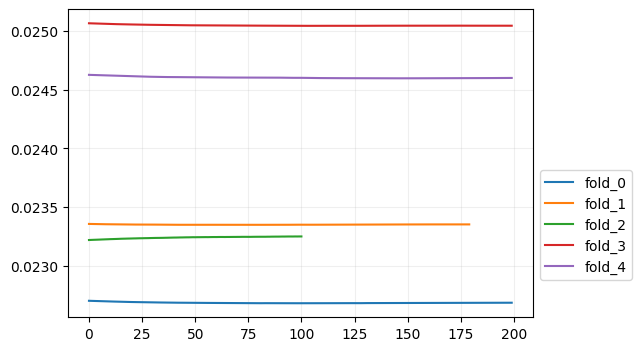

------------------------------
Feature Importance
------------------------------


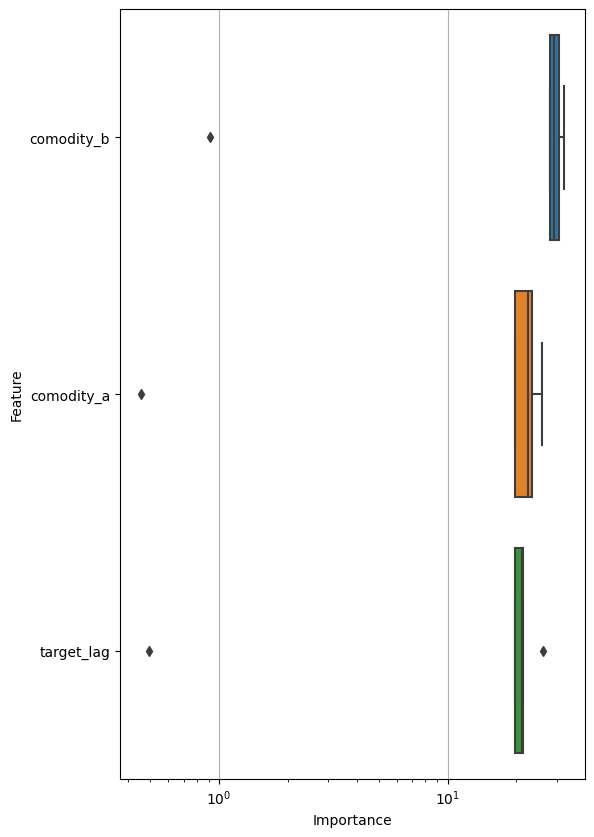

In [11]:
print("---"*10)
print("Learning Curve")
print("---"*10)
plot_learning_curve(dict_learning_curve)
print("---"*10)
print("Feature Importance")
print("---"*10)
plot_importance(fi_df, figsize=(6, 10))

In [12]:
# ------------------ Scoring ------------------
SOL_FILL = -999999
def compute_sharpe(preds: pd.DataFrame, truths: pd.DataFrame) -> float:
    """
    Assumes that date_id is unique in the rows and target0~423 are in the columns
    """
    scores = []
    for p_row, t_row in zip(preds.values, truths.values):
        mask = t_row != SOL_FILL
        if mask.sum() < 2 or np.std(p_row[mask]) == 0 or np.std(t_row[mask]) == 0:
            scores.append(0.0)
        else:
            scores.append(
                np.corrcoef(
                    pd.Series(p_row[mask]).rank(),
                    pd.Series(t_row[mask]).rank()
                )[0, 1]
            )
    arr = np.array(scores)
    corr_mean = arr.mean()
    corr_std = arr.std(ddof=0)
    score = float(corr_mean / corr_std) if corr_std > 0 else 0.0
    return corr_mean, corr_std, score

def reshape_predictions(df_pred, df_train, cv=True):
    """
    Function to reshape prediction results with unique date_id in rows and various targets in columns
    
    Parameters:
    -----------
    df_pred : DataFrame
        DataFrame containing prediction results (includes target_name, date_id, pred columns)
    df_train : DataFrame
        Training data DataFrame (includes date_id)
        
    Returns:
    --------
    DataFrame
        Formatted prediction results (date_id, target_0, target_1, ...)
    """
    targets = [f"target_{i}" for i in range(424)]
    
    # ToDo: for sub can be simplified
    
    # Modify prediction results to have unique date_id in rows and various targets in columns
    if cv:
        df_pred_mod = df_train[["date_id", "fold"]]
    else:
        df_pred_mod = df_train[["date_id"]]
    for tgt in targets:
        tmp = df_pred.loc[df_pred["target_name"]==tgt, :][["date_id", "pred"]].rename(columns={"pred": tgt})
        df_pred_mod = df_pred_mod.merge(tmp, on="date_id", how="left")

    if not cv:
        df_pred_mod.drop("date_id", axis=1, inplace=True)
    
    return df_pred_mod

In [13]:
# Reshape prediction results
df_cv_pred_mod = reshape_predictions(df_cv_pred, train_df)

# Calculate scores for each fold
targets = [f"target_{i}" for i in range(424)]
df_score = pd.DataFrame(columns=["mean", "std", "score"])
for fold in range(5):
    valid_truth = train_labels_train[train_labels_train["fold"] == fold][targets].fillna(SOL_FILL)
    pred_df = df_cv_pred_mod[df_cv_pred_mod["fold"] == fold][targets]
    corr_mean, corr_std, score = compute_sharpe(pred_df, valid_truth)
    df_score.loc[f"fold_{fold}"] = [corr_mean, corr_std, score]

df_score.loc["mean"] = df_score.mean()
df_score.loc["min"] = df_score.min()
df_score.loc["max"] = df_score.max()

df_score.to_csv(f"5fold_cv_score.csv", index=True)
df_cv_pred_mod.to_csv(f"5fold_cv_pred.csv", index=False)
df_score

,mean,std,score
fold_0,0.0366,0.2331,0.1571
fold_1,0.0214,0.2732,0.0783
fold_2,0.0020,0.2481,0.0082
fold_3,0.0363,0.2239,0.1622
fold_4,0.0577,0.2333,0.2474
mean,0.0308,0.2423,0.1306
min,0.0020,0.2239,0.0082
max,0.0577,0.2732,0.2474


In [14]:
def class_to_dict(obj):
    return {k: getattr(obj, k) for k in dir(obj) if not k.startswith('__') and not callable(getattr(obj, k))}

if CFG.wandb:
    import wandb
    from kaggle_secrets import UserSecretsClient
    
    wandb.login(key=UserSecretsClient().get_secret("wandb_api"))
    wandb.init(project="Mitsui", 
               name=CFG.exp_name,
               config=class_to_dict(CFG), 
               tags=[CFG.model])
    wandb.log({
        "mean_mean": df_score.loc["mean", "mean"],
        "std_mean": df_score.loc["mean", "std"],
        "score_mean": df_score.loc["mean", "score"],
        "score_min": df_score.loc["min", "score"],
        "score_max": df_score.loc["max", "score"],
        "score_minmax": df_score.loc["max", "score"] - df_score.loc["min", "score"],
    })

    wandb.finish()

# Submission

In [15]:
NUM_TARGET_COLUMNS = 424

class Predictor:
    def __init__(
        self,
        df_train: pd.DataFrame | None,
        target_pairs_df: pd.DataFrame,
        list_models,
        features
    ):
        self.df_train = df_train  # Noneなら初回に読み込み等でセット
        self.target_pairs_df = target_pairs_df
        self.list_models = list_models
        self.features = features
        self._initialized = False

    def _lazy_init(self):
        """最初の1回だけ重い処理をここで実施（モデルロード等）。"""
        if self._initialized:
            return
        # 必要ならここでモデルロード・前処理器ロードなど
        # 例: self.list_models = load_models_from('/kaggle/input/...')

        # df_train が未セットなら公開ファイルから読み込む（例）
        if self.df_train is None:
            # 例: 公開 train を読む（必要に応じて修正）
            # ここはユーザーのデータ構成に合わせて置き換えてください
            # self.df_train = pd.read_csv('/kaggle/input/xxx/train.csv')
            raise RuntimeError("df_train を外から渡すか、ここで読み込む実装にしてください。")

        self._initialized = True

    def predict(
        self,
        test: pl.DataFrame,
        label_lags_1_batch: pl.DataFrame,
        label_lags_2_batch: pl.DataFrame,
        label_lags_3_batch: pl.DataFrame,
        label_lags_4_batch: pl.DataFrame,
    ) -> pl.DataFrame:

        # 初回だけ重い初期化（評価APIは「最初の predict は時間緩い」のでここに寄せると安全）
        self._lazy_init()

        # 必要に応じて Pandas/Polars を使い分け
        test_df = test.to_pandas()
        date_pred = test["date_id"].to_numpy()[-1]

        # 逐次到着する test を df_train に蓄積（重複 date_id は除外）
        self.df_train = (
            pd.concat((self.df_train, test_df), ignore_index=True)
              .drop_duplicates(subset=["date_id"], keep="last")
              .sort_values(by="date_id")
        )
        self.df_train = self.df_train.iloc[-30:, :].reset_index(drop=True)
        

        # 特徴量生成（既存の関数が pandas 前提なら pandas を渡す）
        df_stack = create_time_series_feature(
            df_train=self.df_train,
            df_pairs=self.target_pairs_df,
            cv=False
        )
        # 今回予測対象の行だけに絞る
        df_stack = df_stack.loc[df_stack["date_id"] == date_pred].reset_index(drop=True)

        # 予測
        df_pred = df_stack[['date_id', 'target_name']].copy()
        df_pred["pred"] = 0.0

        X = df_stack[self.features].to_numpy()

        for model in self.list_models:
            pred = model.predict(X)
            # min-max 正規化してアンサンブル（ゼロ割回避）
            pmin, pmax = np.min(pred), np.max(pred)
            if pmax > pmin:
                pred_norm = (pred - pmin) / (pmax - pmin)
            else:
                pred_norm = np.zeros_like(pred, dtype=float)
            df_pred["pred"] += pred_norm

        # 提出形状（1行×424列）に変換
        df_pred_mod = reshape_predictions(df_pred, test_df, cv=False)

        # Kaggle API は pandas でも polars でもOK。高速化のため polars 返却推奨。
        # カラム名は target_0 ... target_423 の 424 列・行数 1 を満たすこと
        # 必要ならここで列順・列数を明示的に揃える
        expected_cols = [f"target_{i}" for i in range(NUM_TARGET_COLUMNS)]
        df_pred_mod = df_pred_mod.reindex(columns=expected_cols)

        # assert df_pred_mod.isnull().sum().sum() == 0

        return pl.DataFrame(df_pred_mod)



# ==== 評価APIに渡す「関数」はこれ（ラッパ） ====
def predict(
    test: pl.DataFrame,
    label_lags_1_batch: pl.DataFrame,
    label_lags_2_batch: pl.DataFrame,
    label_lags_3_batch: pl.DataFrame,
    label_lags_4_batch: pl.DataFrame,
) -> pl.DataFrame | pd.DataFrame:
    # クラスのメソッドに委譲。サーバからは「ただの関数」に見える
    return predictor.predict(
        test,
        label_lags_1_batch,
        label_lags_2_batch,
        label_lags_3_batch,
        label_lags_4_batch,
    )

In [16]:
if CFG.sub:
    import kaggle_evaluation.mitsui_inference_server

    train_df = pl.read_csv(f'{DATA_DIR}/train.csv').to_pandas()
    target_pairs_df = pl.read_csv(f'{DATA_DIR}/target_pairs.csv').to_pandas()
    
    # Remove last 90 rows from training data
    train_df = train_df[1800:1827].reset_index(drop=True)
    train_df.tail(3)

    # ==== インスタンス作成（ここで状態を保持） ====
    # 例: 既に notebook 上で読み込んだものを渡す
    # predictor = Predictor(df_train=your_df_train, target_pairs_df=target_pairs_df,
    #                       list_models=list_models, features=features)
    
    # とりあえず None のまま置いておき、_lazy_init で読ませるならこう：
    predictor = Predictor(df_train=train_df, target_pairs_df=target_pairs_df,
                          list_models=list_models, features=features)

    # 以降はサンプル通り
    inference_server = kaggle_evaluation.mitsui_inference_server.MitsuiInferenceServer(predict)
    
    if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
        inference_server.serve()
    else:
        inference_server.run_local_gateway(('/kaggle/input/mitsui-commodity-prediction-challenge/',))

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]

  0%|          | 0/424 [00:00<?, ?it/s]